# Goal: Predict if a tweet is about a natural disaster or not

# Data import and EDA

In [7]:
import pandas as pd
import numpy as np

sample=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')
train=pd.read_csv('../input/nlp-getting-started/train.csv')
train.tail(2)

,id,keyword,location,text,target
7593,10848,NaN,NaN,I just heard a really loud bang and everyone i...,0
7594,10849,NaN,NaN,A gas thing just exploded and I heard screams ...,1
7595,10850,NaN,NaN,NWS: Flash Flood Warning Continued for Shelby ...,1
7596,10851,NaN,NaN,RT @LivingSafely: #NWS issues Severe #Thunders...,1
7597,10852,NaN,NaN,#??? #?? #??? #??? MH370: Aircraft debris foun...,1
7598,10853,NaN,NaN,Father-of-three Lost Control of Car After Over...,1
7599,10854,NaN,NaN,1.3 #Earthquake in 9Km Ssw Of Anza California ...,1
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1
7602,10860,NaN,NaN,a siren just went off and it wasn't the Forney...,1


In [8]:
print('Training samples:', train.shape[0])
print('Test sample:', test.shape[0])
print('Proportion of train with missing keyword:', round(train['keyword'].isnull().sum()/train.shape[0], 3))
print('Proportion of test with missing keyword:', round(test['keyword'].isnull().sum()/test.shape[0],3))
print('Proportion of train with missing location:', round(train['location'].isnull().sum()/train.shape[0],3))
print('Proportion of test with missing locaiton:', round(test['location'].isnull().sum()/test.shape[0],3))

Training samples: 7613
Test sample: 3263
Proportion of train with missing keyword: 0.008
Proportion of test with missing keyword: 0.008
Proportion of train with missing location: 0.333
Proportion of test with missing locaiton: 0.339


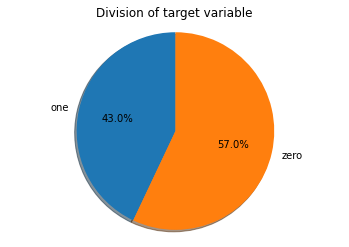

In [36]:
import matplotlib.pyplot as plt 

one=train[train['target']==1]
zero=train[train['target']==0]
labels='one', 'zero'
sizes=[len(one), len(zero)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Division of target variable')
plt.show()

# Tweet cleaning

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer 

# special tokenizer for tweets
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)  
# a list of English stopwords
stopwords = stopwords.words('english')
# initialize stemming class
stemmer = PorterStemmer() 

print('examples before cleaning:')
print(train.text[55:60])

def tweet_cleaner(tweet):
    tweet2 = re.sub(r'^RT[\s]+', '', tweet)                           # remove 'RT' retweet
    tweet2 = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet2)              # remove hyperlinks
    tweet2 = re.sub(r'#', '', tweet2)                                 # remove only hashtags
    tokens=tokenizer.tokenize(tweet2)                                 # tokenize
    tokens=[token for token in tokens if token not in stopwords]      # remove stop words
    tokens=[token.strip(string.punctuation) for token in tokens]      # remove punctuation
    tokens=[stemmer.stem(token) for token in tokens]                  # stemming the words
    tokens=list(filter(None, tokens))                                 # removing blank tokens
    return tokens
           

train['text']=train['text'].apply(tweet_cleaner)
test['text']=test['text'].apply(tweet_cleaner)

print('\nexamples after cleaning:')
print(train.text[55:60])

examples before cleaning:
55    #Kurds trampling on Turkmen flag later set it ...
56    TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE O...
57    Set our hearts ablaze and every city was a gif...
58    They sky was ablaze tonight in Los Angeles. I'...
59    How the West was burned: Thousands of wildfire...
Name: text, dtype: object

examples after cleaning:
55    [kurd, trampl, turkmen, flag, later, set, abla...
56    [truck, ablaz, r21, voortrekk, ave, outsid, ta...
57    [set, heart, ablaz, everi, citi, gift, everi, ...
58    [sky, ablaz, tonight, lo, angel, i'm, expect, ...
59    [west, burn, thousand, wildfir, ablaz, califor...
Name: text, dtype: object


# Frequency dictionary

In [15]:
freqs={}
for y, tweet in zip(train['target'],train['text']):
    for word in tweet:
        pair=(word, y)
        if pair in freqs:
            freqs[pair] +=1
        else:
            freqs[pair] =1

In [16]:
# # getting top 20 words
# top_20_whole_key=sorted(freqs, key=freqs.get, reverse=True)[:20]
# # taking only the first part of the key
# top_20=[word[0] for word in top_20_whole_key]
# # remove duplicated words
# top_words=list(set(top_20))  

# or a personal selection of words can be used
selected=['earthquak','lake','disast','crash','love','fruit','nigeria','polic','site','street',
         'heart', 'center','risk','wish','truck','first','taxi','first','financi','guy','murder']

# The frequency of the words in the disaster and non-disaster sets
scatter_data=[]
for word in selected:
    disaster=0
    normal=0
    if (word ,1) in freqs:
        disaster=freqs[(word, 1)]
    if (word, 0) in freqs:
        normal=freqs[(word, 0)]
    scatter_data.append([word, disaster, normal])        

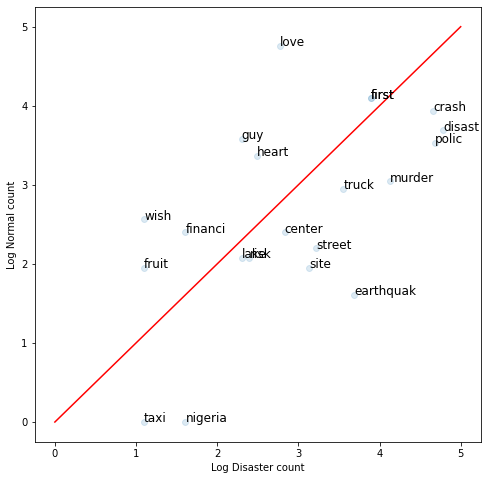

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
x=np.log([x[1]+1 for x in scatter_data])
y=np.log([y[2]+1 for y in scatter_data])
ax.scatter(x,y,alpha=.15)
plt.xlabel('Log Disaster count')
plt.ylabel('Log Normal count')
for i in range(0, len(scatter_data)):
    ax.annotate(scatter_data[i][0], (x[i], y[i]), fontsize=12)
ax.plot([0, 5], [0, 5], color = 'red')
plt.show()


# Feature extraction

In [27]:
def feature_extraction(tweet, freqs):
    x=np.zeros((1,3))  
    x[0,0]=1
    for word in tweet:
        x[0,1]+=freqs.get((word, 1.0),0)
        x[0,2]+=freqs.get((word, 0.0),0)
    assert(x.shape==(1,3))  
    return x

X_train=np.zeros((len(train),3))
for i in range(len(train)):
    X_train[i,:]=feature_extraction(train.loc[i,'text'],freqs)
    
X_test=np.zeros((len(test),3))
for i in range(len(test)):
    X_test[i,:]=feature_extraction(test.loc[i,'text'],freqs)
print('3 rows of new training data:')
print(X_train[:3])

new training data:
[[  1. 149. 141.]
 [  1. 393. 117.]
 [  1. 248. 123.]]


# Traing model, predict and submit
- this got a score of 76.3

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

LR=LogisticRegressionCV(fit_intercept=False, cv=5).fit(X_train, train['target'])

In [ ]:
sample.head(2)

In [ ]:
preds=LR.predict(X_test)
# predictions=pd.Series(preds, name='target')
# ids=pd.Series(test.id, name='id')
# submission=pd.concat([ids, predictions], axis=1)
# submission.to_csv("freq_NLP.csv",index=False)

# Naive Bayes

# Training model

In [85]:
def train_naive_bayes(freqs,train_X,train_y):
    loglikelihood={}
    logprior=0
    
    # get every unique word from freqs dictionary
    vocab=set(pair[0] for pair in freqs.keys())
    V=len(vocab)
    
    # count the number of disaster and non disaster words
    N_disaster = N_normal = 0
    for pair in freqs.keys():
        if pair[1] > 0:
            N_disaster+=freqs[pair]
        else:
            N_normal+=freqs[pair]
    
    # calculation logprior
    D=len(train_X)
    D_one=sum(train.target)
    D_zero=len(train)-sum(train.target)
    logprior=np.log(D_one)-np.log(D_zero)
    
    # creating the log likelihood for each word (greater than zero means a disaster tweet)
    for i,word in enumerate(vocab):
        # getting the frequency of each word
        freq_one=freqs.get((word, 1), 0)
        freq_zero=freqs.get((word, 0), 0)
        # the probability of each for both targets using laplacian smoothing
        p_w_one=(freq_one + 1)/(D_one+V)
        p_w_zero=(freq_zero + 1)/(D_zero+V)
        # loglikelihood dict
        loglikelihood[word]=np.log(p_w_one)-np.log(p_w_zero)
    
    return loglikelihood, logprior    

loglikelihood, logprior = train_naive_bayes(freqs, train.text, train.target)

# Making predictions

In [106]:
results=[] 
for tweet in test['text']:
    for word in tweet:
        p=logprior
        if word in loglikelihood:
            p+=loglikelihood[word]
    results.append(p)
preds=[1 if x>0 else 0 for x in results]

# Submitting prediction
- score was 67.5, a lot worse that with the frequeny dictionary

In [107]:
predictions=pd.Series(preds, name='target')
ids=pd.Series(test.id, name='id')
submission=pd.concat([ids, predictions], axis=1)
submission.to_csv("bayes_NLP.csv",index=False)